## Multiclass classifiers

So far, we have been dealing with binary classifiers. However, many classification problems are multiclass, that is, there are many classes we can be choosing from. For example, the `20newsgroups` dataset has 20 different classes, and the objective is to classify items among these 20 classes. We can access the dataset using:

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
X = newsgroups_train.data
y = newsgroups_train.target
print(X[0:5])
print(y[0:5])
print(len(set(y)))

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n", "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 1

## Multiclass Logistic Regression

Although sklearn deals with multiclass classification automatically, in PyTorch we have to take care of some things:

1. The number of outputs of the classification layer must be equal to the number of classes; and
1. Instead of using a sigmoid, we will be using a SoftMax activation function.
1. Use the Cross Entropy loss instead of the Binary Cross Entropy loss.

How does that work?

First, let's look at the number of outputs.

In the binary classifier, we had the equation:

$$
\boldsymbol{z} = \boldsymbol{x}\boldsymbol{w^T} + b
$$

and this was written as:

$$
\boldsymbol{z} = \begin{bmatrix} x_1 & x_2 & \cdots x_d \end{bmatrix} \begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_d \end{bmatrix} + b
$$

### Adding more outputs to our logistic regression

Now, we are going to add another line of weights in $\boldsymbol{w}$, which actually means we will have another columns of weights in $\boldsymbol{w^T}$:

$$
\boldsymbol{z} = \begin{bmatrix} x_1 & x_2 & \cdots x_d \end{bmatrix} \begin{bmatrix} w_{1,1} & w_{1,2} \\ w_{2,1} & w_{2,2} \\ \vdots  & \vdots \\ w_{d,1} & w_{d,2} \end{bmatrix} + \begin{bmatrix}b_1& b_2\end{bmatrix}
$$

Thus, $\boldsymbol{z} \in \mathbb{R}^{1 \times 2}$, that is, there are *two* elements of $\boldsymbol{z}$ for each input $\boldsymbol{x}$.

We can further expand this idea and add many rows to $\boldsymbol{w}$, up to $c$ rows, which leads to:

$$
\boldsymbol{z} = \begin{bmatrix} x_1 & x_2 & \cdots x_d \end{bmatrix} \begin{bmatrix} w_{1,1} & w_{1,2} & \cdots & w_{1,c} \\ w_{2,1} & w_{2,2} & \cdots & w_{2,c} \\ \vdots  & \vdots & \ddots & \vdots \\ w_{d,1} & w_{d,2} & \cdots & w_{d,c} \end{bmatrix} + \begin{bmatrix}b_1& b_2 & \cdots & b_c\end{bmatrix}
$$

Now, our logit $\boldsymbol{z}$ has as many as $c$ dimensions. Let's make $c$ the number of classes we have in our problem. Now, we obtain the output $\boldsymbol{y}$ by normalizing $\boldsymbol{z}$ using a specific function.

In our problem, we are assuming that each document can have only one of a set of $c$ known classes. Hence, our output must me a probability distribution of classes, conditioned to the input, or:

$$
y_i = P(C = c_i | \boldsymbol{x})
$$

Such a normalization can be obtained using:

$$
\boldsymbol{y} = \text{Softmax}(\boldsymbol{z}) = \frac{e^{z_i}}{\sum_{i=1}^c e^{z_{i}}}
$$

In other words: calculate the exponential of all logits, and then normalize them by the sum of all logit exponentials.

Softmax is important because, by applying it, the outputs become interpretable as a probability distribution over the possible classes in the output. The exponential is important because it accounts for uncertainty: logits with higher certainty are typically more extreme, and lead to distributions with lower entropy.

Last, we use Cross Entropy loss because the distribution is no longer 0-1. Instead, the cross entropy is calculated along all dimensions of the output.

### Exercise: evaluate a model

Models supporting many classes tend to have more parameters, hence it becomes progressively more difficult to train them adequately. Because of that, this exercise will start with pre-trained weights. See - we do everything the same way as before. However, we must:

1. Define the model object **exactly as it was trained**
1. Load the weights from a state dictionary.

PyTorch forbids saving and loading via joblib because that could allow executing malicious code in the machine that loads the models.

In [2]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load('fakenews_tokenizer.model')
padding_idx = sp.piece_to_id('<PAD>')

def pad_to_len(sequences, pad_idx, max_len):
    padded = []
    for s in sequences:
        if len(s) >= max_len:
            padded.append(s[:max_len])
        else:
            padded.append(s + [pad_idx] * (max_len - len(s)))
    return padded


In [3]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

class MulticlassClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, n_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_dim,
                                      padding_idx=padding_idx)
        self.clf = nn.Linear(embedding_dim, n_classes)

    def summarize(self, x):
        return x.mean(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.summarize(x)
        x = self.clf(x)
        return x



In [4]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='test')
X = newsgroups_train.data
y = newsgroups_train.target

allowed_classes = set(range(20))
n_classes = len(allowed_classes)
class_indices = [i for i in range(len(y)) if y[i] in allowed_classes]
tokens = sp.encode_as_ids([X[i] for i in class_indices])
tokens = pad_to_len(tokens, padding_idx, 500)
tokens = torch.tensor(tokens)

y = torch.tensor(y[class_indices])
print(tokens.shape, y.shape)

torch.Size([7532, 500]) torch.Size([7532])


In [5]:
model = MulticlassClassifier(
    vocab_size=5000,
    embedding_dim=60,
    n_classes=20
)

model.load_state_dict(torch.load('newsgroups_mean.pth', weights_only=True))
model.eval()

MulticlassClassifier(
  (embedding): Embedding(5000, 60, padding_idx=3)
  (clf): Linear(in_features=60, out_features=20, bias=True)
)

In [6]:
from sklearn.metrics import accuracy_score
y_pred_probs = model(tokens)
y_pred = torch.argmax(y_pred_probs, axis=1)
y_pred = y_pred.detach().cpu().numpy()
y_true = y.detach().cpu().numpy()

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7066


## Visualizing embeddings

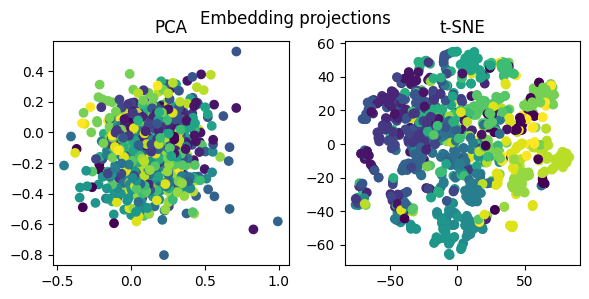

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

indices = torch.randperm(tokens.size(0))[:1000]
tokens_sample = tokens[indices]
y_sample = y[indices]
embeddings_post = model.summarize(model.embedding(tokens_sample)).detach().cpu().numpy()

pca = PCA(n_components=2)
embeddings_post_pca = pca.fit_transform(embeddings_post)
tsne = TSNE(n_components=2, perplexity=5)
embeddings_post_tsne = tsne.fit_transform(embeddings_post)
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.scatter(embeddings_post[:,0], embeddings_post[:,1], c=y_sample)
plt.title("PCA")
plt.subplot(1,2,2)
plt.scatter(embeddings_post_tsne[:,0], embeddings_post_tsne[:,1], c=y_sample)
plt.title("t-SNE")
plt.tight_layout()
plt.suptitle("Embedding projections")
plt.show()

## Dealing with large datasets

Some datasets don't fit into our RAM memory, or into our GPU memory. To deal with such datasets, we need to progressively retrieve items and use them to perform small optimization steps. These small optimization steps are called *minibatches*. A minibatch typically has 16 to 128 items, but this can absolutely change according to your problem.

PyTorch has an interface to make minibatches. It uses a combination of two types of objects: `DataSet` and `DataLoader`. A `DataSet` has the responsibility of retrieving one item from a set. A `DataLoader` combines the items returned from `DataSet` into batches. See the demo below:

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data # If data does not fit memory, change this to e.g. indexes or file pointers
        self.labels = labels

    def __len__(self): # Returns the number of items in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx], self.labels[idx]
        return sample

# Create some sample data
data = torch.randn(100, 2)  # 100 samples, each with 2 features
labels = torch.randint(0, 2, (100,1))  # 100 labels (binary classification)

# Create the dataset
dataset = MyDataset(data, labels)
print(dataset[1]) # This actually calls __getitem__

(tensor([-1.1678,  0.3940]), tensor([1]))


In [9]:
# Create a DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
)

# Iterate through the DataLoader
for x, y in dataloader:
    print(x)
    print(y)
    break  # Print only the first batch for demonstration

tensor([[-1.1678,  0.3940],
        [-1.1061, -0.1787],
        [-0.4160,  0.3750],
        [ 0.8272, -0.3018]])
tensor([[1],
        [0],
        [0],
        [1]])


Now, we have two nested training loops: we need to train for each epoch, and, within each epoch, we need to train for each batch. Check the code below. I commented some lines so you don't accidentally run it.

In [10]:
def train_one_batch(X, y, model, optimizer, criterion):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = torch.mean(criterion(y_pred, y))
    loss.backward()
    optimizer.step()
    return loss.item()

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for X, y in tqdm(dataloader):
        loss = train_one_batch(X, y, model, optimizer, criterion)
        total_loss += loss
    return total_loss / len(dataloader)

losses = []
n_epochs = 10
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in tqdm(range(n_epochs)):
    #epoch_loss = train_one_epoch(model, dataloader, optimizer, F.cross_entropy)
    #losses.append(epoch_loss)
    break

  0%|          | 0/10 [00:00<?, ?it/s]


## Exercise: use pre-trained weights from a different architecture

Check the file `train_newsgroups_rnn_minibatch.py`. It has code to train an RNN-based classifier over the newsgroups dataset. Don't run it - it will take a while. Instead, open it, and find:

1. The model definition
2. The file where the model weights are

Instantiate a model using the neural network trained in `train_newsgroups_rnn_minibatch.py` and evaluate its accuracy and visualize its embeddings.


In [11]:
# Make your solution here

In [1]:
# This is my solution. Don't look at it!



import torch
import torch.nn as nn
import torch.nn.functional as F

import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load('fakenews_tokenizer.model')
padding_idx = sp.piece_to_id('<PAD>')

def pad_to_len(sequences, pad_idx, max_len):
    padded = []
    for s in sequences:
        if len(s) >= max_len:
            padded.append(s[:max_len])
        else:
            padded.append(s + [pad_idx] * (max_len - len(s)))
    return padded

from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='test')
X = newsgroups_train.data
y = newsgroups_train.target

allowed_classes = set(range(20))
n_classes = len(allowed_classes)
class_indices = [i for i in range(len(y)) if y[i] in allowed_classes]
tokens = sp.encode_as_ids([X[i] for i in class_indices])
tokens = pad_to_len(tokens, padding_idx, 500)
tokens = torch.tensor(tokens)

y = torch.tensor(y[class_indices])
print(tokens.shape, y.shape)

class MulticlassClassifierRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_dim,
                                      padding_idx=padding_idx)
        self.rnnlayer = nn.RNN(
            input_size=embedding_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True,
        )
        self.clf = nn.Linear(embedding_dim, n_classes)

    def summarize(self, x):
        x, _ = self.rnnlayer(x)
        x = torch.mean(x, dim=1)
        return x

    def forward(self, x):
        x = self.embedding(x)
        x = self.summarize(x)
        x = self.clf(x)
        return x



model = MulticlassClassifierRNN(
    vocab_size=5000,
    embedding_dim=60,
    n_classes=20
)
model.load_state_dict(torch.load('newsgroups_rnn.pth', weights_only=True))
model.eval()

from sklearn.metrics import accuracy_score
y_pred_probs = model(tokens)
y_pred = torch.argmax(y_pred_probs, axis=1)
y_pred = y_pred.detach().cpu().numpy()
y_true = y.detach().cpu().numpy()

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")


torch.Size([7532, 500]) torch.Size([7532])
Accuracy: 0.5441


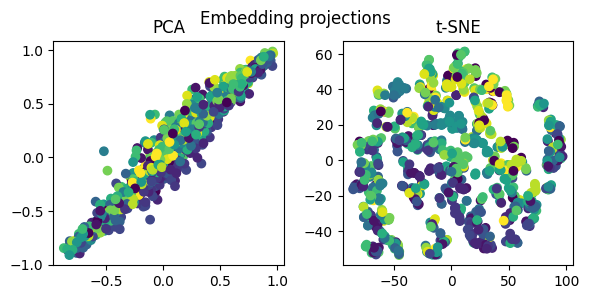

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

indices = torch.randperm(tokens.size(0))[:1000]
tokens_sample = tokens[indices]
y_sample = y[indices]
embeddings_post = model.summarize(model.embedding(tokens_sample)).detach().cpu().numpy()

pca = PCA(n_components=2)
embeddings_post_pca = pca.fit_transform(embeddings_post)
tsne = TSNE(n_components=2, perplexity=5)
embeddings_post_tsne = tsne.fit_transform(embeddings_post)
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.scatter(embeddings_post[:,0], embeddings_post[:,1], c=y_sample)
plt.title("PCA")
plt.subplot(1,2,2)
plt.scatter(embeddings_post_tsne[:,0], embeddings_post_tsne[:,1], c=y_sample)
plt.title("t-SNE")
plt.tight_layout()
plt.suptitle("Embedding projections")
plt.show()

<generator object Module.parameters at 0x7fb2a062ec00>
torch.Size([60, 60])
torch.Size([60, 60])


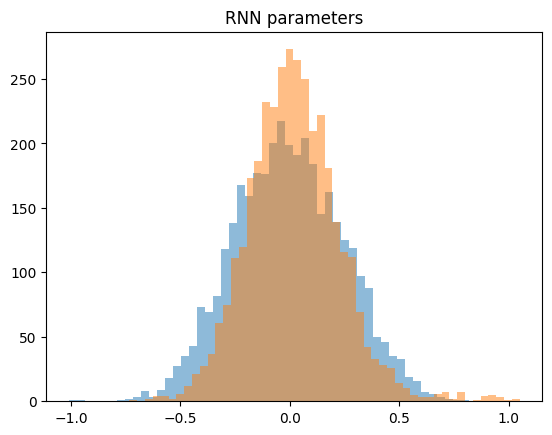

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
# Histogram of parameters: many parameters close to zero!
print(model.rnnlayer.parameters())
plt.figure()
for param in list(model.rnnlayer.parameters())[0:2]:
    print(param.shape)
    plist = param.detach().cpu().numpy().flatten()
    plt.hist(plist, bins=50, alpha=0.5)
plt.title("RNN parameters")
plt.show()
plt.figure()

<generator object Module.parameters at 0x7fb29854d8c0>
torch.Size([60, 60])
torch.Size([60, 60])


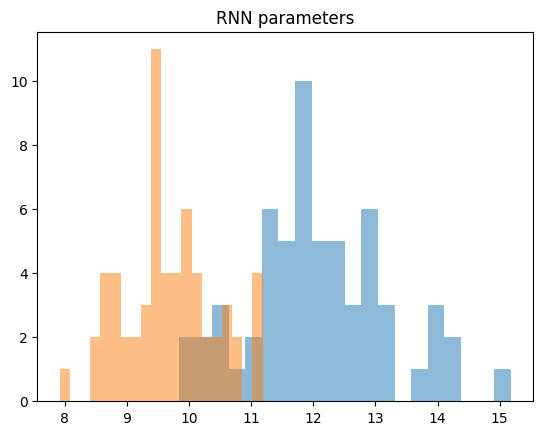

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
# Histogram of neurons: many parameters close to zero!
print(model.rnnlayer.parameters())
plt.figure()
for param in list(model.rnnlayer.parameters())[0:2]:
    print(param.shape)
    plist = ((param.detach().cpu().numpy()**2)**0.5).sum(axis=1)
    plt.hist(plist, bins=20, alpha=0.5)
plt.title("RNN parameters")
plt.show()
plt.figure()

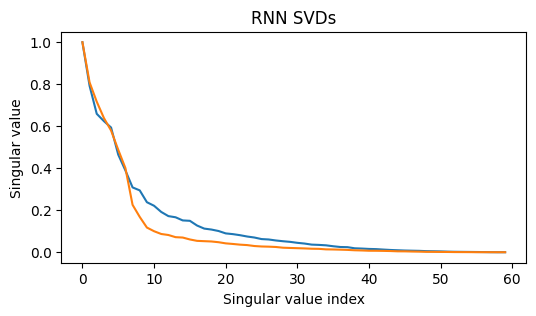

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
# SVD of parameters: most energy in first 10 singular values!
plt.figure(figsize=(6, 3))
for param in list(model.rnnlayer.parameters())[0:2]:
    s = torch.linalg.svdvals(param).detach().numpy()**2
    plt.plot(s / s.max())
plt.title("RNN SVDs")
plt.xlabel("Singular value index")
plt.ylabel("Singular value")
#plt.yscale('log')
plt.show()
plt.figure()

## Exercise: analyze a dataset

The dataset defined below receives a sequence of tokens as input.

1. When it is used to train a classifier, what are the inputs, and what is the "output class"?
1. If a classifier using this dataset estimates $P(y | x)$, what is $y$ and what is $x$ in the real world? 

In [6]:
class TextDataset(Dataset):
    def __init__(self, data, length):
        self.data = data
        self.length = length

    def __len__(self): # Returns the number of items in the dataset
        return len(self.data) - self.length

    def __getitem__(self, idx):
        idx_start = idx
        idx_end = idx_start + self.length-1
        x = self.data[idx_start:idx_end]
        y = self.data[idx_start+1:idx_end+1]
        return x, y

NameError: name 'Dataset' is not defined